# Day 6, directed acyclic graph

Today we are given a tree, essentiallly a directed, acyclic graph. Trees can be undirected too, but since once node (body) orbits another, there is a clear direction.

The first task is to sum the distances from root body (the one object in the graph that doesn't orbit around other bodies) for all bodies in the graph. So we only need to traverse the graph, and for each new node add their depth $d_n$, defined as $d_{n-1} + 1$, to the total.


In [1]:
from __future__ import annotations

import aocd

data = aocd.get_data(day=6, year=2019)

In [2]:
from collections import deque
from typing import Dict, Iterable, Mapping, Optional, Set, Tuple

# A directed graph is a mapping of node names referencing a set of other node names
DGraph = Mapping[str, Set[str]]


def read_orbits(lines: Iterable[str]) -> DGraph:
    graph: Dict[str, Set[str]] = {}
    for line in lines:
        center, _, body = line.strip().partition(")")
        graph.setdefault(center, set()).add(body)
    return graph


def walk(graph: DGraph, root: str = "COM") -> Iterable[Tuple[str, int, Optional[str]]]:
    """Walk a graph, yielding (name, depth, orbits) tuples

    name is a body in the graph, depth the number of steps it is removed from the root
    and orbits the name of the body it is orbiting around.

    """
    stack = deque([(root, 0, None)])
    while stack:
        body, depth, orbits = stack.pop()
        yield (body, depth, orbits)
        stack += ((b, depth + 1, body) for b in graph.get(body, ()))


def total_direct_and_indirect_orbits(graph: DGraph) -> int:
    return sum(d for _, d, _ in walk(graph))


part1_testinput = """\
COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L
""".splitlines()
part1_testorbits = read_orbits(part1_testinput)
assert total_direct_and_indirect_orbits(part1_testorbits) == 42

In [3]:
orbits = read_orbits(data.splitlines())
print("Part 1:", total_direct_and_indirect_orbits(orbits))

Part 1: 142915


## Part 2, common ancestor finding

We are basically tasked with finding a common ancestor for both the `YOU` and `SAN` nodes, and add up the relative depths from that common ancestor. In the test input in the description, that common ancestor is `D`, and `YOU` and `SAN` orbit around objects that are at relative depths 1 an d3 from that common ancestor, hence the answer being 4.

We can find the common ancestor by inverting our graph (but _keeping_ the depth information we already calculated for part 1), and then traversing up the graph for both `YOU` and `SAN` until you find a common body at the same depth; we'll have to first traverse up the one object that's deepest into the tree to make it easier to find the common ancestor at the same depth. Then just take the relative depths and we are done!

E.g. for the test input, `YOU` orbits `(K, 6)`, and `SAN` orbits `(I, 4)`. We move `YOU` to an orbit at depth 4 first, which takes 2 steps, to `(E, 4)`. That's not the same body as `(I, 4)`, so traverse to the next body for both, and we arrive at `(D, 3)` for both. Our answer is then `(6 - 3) + (4 - 3) == 4`.


In [4]:
from typing import Callable, Iterator


def minimum_orbital_transfers(
    graph: DGraph,
    from_: str = "YOU",
    to: str = "SAN",
    _graphcb: Optional[Callable[[str],]] = None,
) -> int:
    # (d)epth is for orbiting (b)ody, so for (o)rbited, depth is d - 1
    orbiting: Dict[str, Tuple[str, int]] = {
        b: (o, d - 1) for b, d, o in walk(graph) if o is not None
    }

    def traverse(pair: Tuple[str, int]) -> Iterator[Tuple[str, int]]:
        """Traverse orbiting bodies inwards"""
        while pair:
            if _graphcb:
                _graphcb(pair[0])
            yield pair
            pair = orbiting.get(pair[0])

    traversals = traverse(orbiting[from_]), traverse(orbiting[to])
    positions = [next(t) for t in traversals]
    start_depths = [d for _, d in positions]

    while positions[0] != positions[1]:
        # if not equal, only traverse the furtherst
        if positions[0][1] > positions[1][1]:
            positions[0] = next(traversals[0])
        elif positions[0][1] < positions[1][1]:
            positions[1] = next(traversals[1])
        else:
            positions = [next(t) for t in traversals]
    common_depth = positions[0][1]
    return sum(d - common_depth for d in start_depths)


part2_testinput = part1_testinput + ["K)YOU", "I)SAN"]
part2_testorbits = read_orbits(part2_testinput)
assert minimum_orbital_transfers(part2_testorbits) == 4

In [5]:
print("Part 2:", minimum_orbital_transfers(orbits))

Part 2: 283


## Visualisation

This is what the test tree looks like:

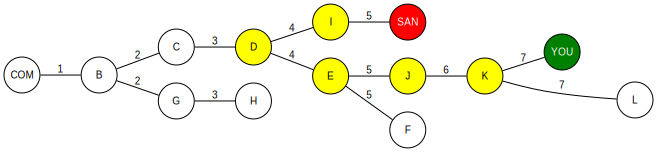

In [6]:
import subprocess

import graphviz
from IPython.display import Markdown, display


def plot_graph(
    graph: DGraph,
    root: str = "COM",
    edge_attr: Optional[Mapping[str, str]] = None,
    node_attr: Optional[Mapping[str, str]] = None,
    **graph_attr: str,
) -> graphviz.Digraph:
    graph_attr = {
        "ratio": "compress",
        **graph_attr,
    }
    edge_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "dir": "none",
        **(edge_attr or {}),
    }
    node_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "shape": "circle",
        "fixedsize": "true",
        **(node_attr or {}),
    }
    dot = graphviz.Digraph("orbits", strict=True)
    dot.attr(**graph_attr)
    dot.attr("edge", **edge_attr)
    dot.attr("node", **node_attr)
    colours = {"YOU": "green", "SAN": "RED"}
    path = set()
    minimum_orbital_transfers(graph, _graphcb=path.add)
    nodewalker = walk(graph)

    for body, depth, orbiting in nodewalker:
        endattrs = {}
        if body in colours:
            endattrs = {
                "fillcolor": colours[body],
                "style": "filled",
                "fontcolor": "white",
            }
        elif body in path:
            endattrs = {"fillcolor": "yellow", "style": "filled"}
        if orbiting:
            dot.edge(orbiting, body, label=str(depth))
        dot.node(body, **endattrs)

    try:
        # attempt to process the graph through unflatten, if available
        result = subprocess.run(
            ["unflatten", "-l3"], input=dot.source, capture_output=True, encoding="utf8"
        )
        if result.returncode == 0:
            dot = graphviz.Source(result.stdout)
    except OSError:
        pass

    return dot


display(Markdown("## Visualisation\n\nThis is what the test tree looks like:"))
plot_graph(part2_testorbits, rankdir="LR")

## Visualisation

The puzzle input data is a lot larger:

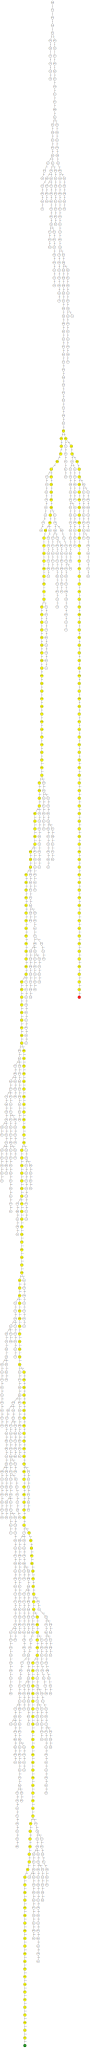

In [7]:
display(Markdown("## Visualisation\n\nThe puzzle input data is a lot larger:"))
plot_graph(
    orbits,
    nodesep="0.20",
    node_attr={"fontsize": "8.0", "width": ".4"},
    edge_attr={"fontsize": "8.0"},
)